# Introduction to the log-binning method

The log-binning method has been used for visualizing the heavy tails of distributions as well as for estimating the power-law exponent in those tails.

## Preparation

We first define some basic functions:

In [122]:
import math, random

# get the distribution for a given set of x
def get_distr(xs):
    distr = {}
    for x in xs:
        distr[x] = distr.setdefault(x, 0) + 1
    return distr

# print the distribution to the file
def print_distr(distr, filename0):
    fn0 = open(filename0, "w")
    sum0 = sum(distr.values())
    for x in sorted(distr.keys()):
        fn0.write("%.10f %.10f %.10f\n"%(x, distr[x], sum0))
    fn0.close()

# draw one value from the power-law distribution
# following Clauset et al., SIAM Rev. (2009)
def get_powerlaw_int(expo, xmin):
    expo0 = -1. / (float(expo) - 1.)
    rand = random.random()
    return int((xmin - 0.5) * pow(1. - rand, expo0) + 0.5)

# get a set of x following the power-law distribution 
# for given power-law exponent and lower and upper bounds, and the number of x 
def get_xs(alpha, x_min, x_max, n_total):
    xs = []
    for i in range(n_total):
        while True:
            x = get_powerlaw_int(alpha, x_min)
            if x < x_max:
                break
        xs.append(x)
    return xs

Before introducing the log-binning method, we also define the function for plotting the distribution in a log-log scale:

In [123]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import zeta

def f(x, num_x, alpha):
    return np.power(list(x), -alpha) / zeta(alpha) * float(num_x)

def plot(distr, num_x, alpha):
    x = distr.keys()
    y = distr.values()
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('x')
    plt.ylabel('frequency of x')
    plt.plot(x, y, 'r.', x, f(x, num_x, alpha), 'k-')
    plt.grid(True)
    plt.show()

After setting up the parameters, we generate a power-law distribution of discrete variable x and plot it in a log-log scale. The frequency of x is denoted by n(x) hereafter.

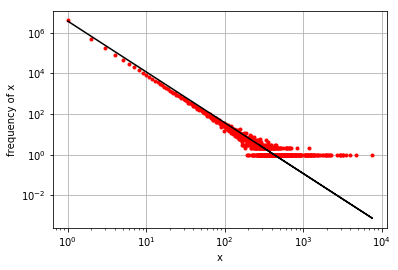

In [124]:
# seed for random number generator
random.seed(1)

# parameters
# power-law exponent
alpha = 2.5
# lower bound of x
x_min = 1
# upper bound of x
x_max = 10000000
# number of x
num_x = 5000000

# generate power-law distribution
xs = get_xs(alpha, x_min, x_max, num_x)
distr = get_distr(xs)
plot(distr, num_x, alpha)
#print_distr(distr, "distr.txt")

In the above figure, the black line denotes the original power-law distribution for the discrete value of x. The numerical distribution shows the discrepancy from the functional form for the tail part, despite the importance of the tail part. For clearer visualization or reducing the noise, binning can be applied.


## Linear binning

The size of each bin is the same as "binsize". The value of each bin is given as the sum of n(x) for the bin.

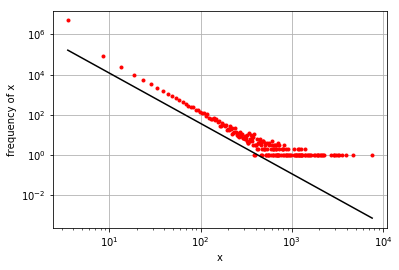

In [125]:
def get_linbin(distr, binsize, binstart):
    distr_bin = {}
    b0 = binstart
    b1 = b0 + binsize
    bc = b0 + binsize * 0.5

    for x in sorted(distr.keys()):
        while x >= b1:
            b0 += binsize
            b1 = b0 + binsize
            bc = b0 + binsize * 0.5
        distr_bin[bc] = distr_bin.setdefault(bc, 0) + distr[x]

    return distr_bin

# linear binning
binsize = 5
binstart = min(xs)
distr_bin = get_linbin(distr, binsize, binstart)
plot(distr_bin, num_x, alpha)
#print_distr(distr_bin, "distr_linbin.txt")

The linear binning of the heavy-tailed distributions does not help to improve the visualization. Thus one can apply the logarithmic binning or log binning.


## Log binning (naive sum)

The size of bins is exponentially increasing by the factor "binsize + 1". The value of each bin is given as the sum of n(x) for the bin.

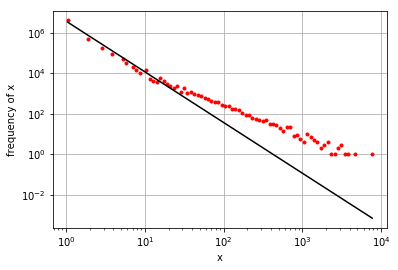

In [126]:
def get_logbin(distr, binsize, binstart):
    distr_bin = {}
    b0 = binstart
    b1 = b0 + binsize
    bc = b0 + binsize * 0.5

    for x in sorted(distr.keys()):
        while math.log(x) >= b1:
            b0 += binsize
            b1 = b0 + binsize
            bc = b0 + binsize * 0.5
        xc = math.exp(bc)
        distr_bin[xc] = distr_bin.setdefault(xc, 0) + distr[x]

    return distr_bin

# log binning
binsize = 0.1
binstart = math.log(min(xs))
distr_bin = get_logbin(distr, binsize, binstart)
plot(distr_bin, num_x, alpha)
#print_distr(distr_bin, "distr_logbin.txt")

The naive log binning makes the visualization worse. Each point should be properly normalized. Here we have two options: (i) The sum of n(x) in each bin is divided by the number of data points in the bin. (ii) The sum of n(x) in each bin is divided by the period (size) of the bin.


## Log binning (division by the number of data points)

The size of bins is exponentially increasing by the factor "binsize + 1". The value of each bin is given as the sum of n(x) for the bin divided by the number of data points in the bin.

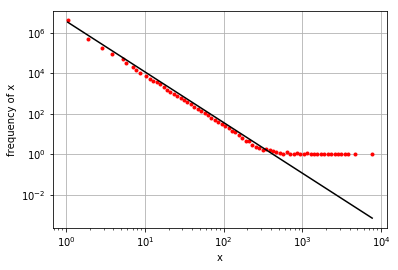

In [127]:
def get_logbin_number(distr, binsize, binstart):
    distr_bin = {}
    bin_number = {}
    b0 = binstart
    b1 = b0 + binsize
    bc = b0 + binsize * 0.5

    for x in sorted(distr.keys()):
        while math.log(x) >= b1:
            b0 += binsize
            b1 = b0 + binsize
            bc = b0 + binsize * 0.5
        xc = math.exp(bc)
        distr_bin[xc] = distr_bin.setdefault(xc, 0) + distr[x]
        bin_number[xc] = bin_number.setdefault(xc, 0) + 1

    return distr_bin, bin_number

# log binning with bin number
binsize = 0.1
binstart = math.log(min(xs))
distr_bin, bin_number = get_logbin_number(distr, binsize, binstart)
for x in distr_bin.keys():
    distr_bin[x] /= bin_number[x]
plot(distr_bin, num_x, alpha)
#print_distr(distr_bin, "distr_logbin_number.txt")

The log binning with the division by the number of data points successfully improves the visualization, while the tail part (i.e., x > 300) still deviates from the original functional form.


## Log binning (division by the period of the bin)

The size of bins is exponentially increasing by the factor "binsize + 1". The value of each bin is given as the sum of n(x) for the bin divided by the period of the bin.

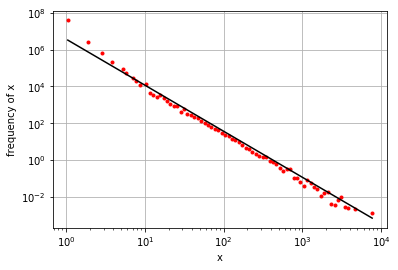

In [128]:
def get_logbin_period(distr, binsize, binstart):
    distr_bin = {}
    bin_period = {}
    b0 = binstart
    b1 = b0 + binsize
    bc = b0 + binsize * 0.5

    for x in sorted(distr.keys()):
        while math.log(x) >= b1:
            b0 += binsize
            b1 = b0 + binsize
            bc = b0 + binsize * 0.5
        xc = math.exp(bc)
        distr_bin[xc] = distr_bin.setdefault(xc, 0) + distr[x]
        bin_period[xc] = math.exp(b1) - math.exp(b0)

    return distr_bin, bin_period

# log binning with bin period
binsize = 0.1
binstart = math.log(min(xs))
distr_bin, bin_period = get_logbin_period(distr, binsize, binstart)
for x in distr_bin.keys():
    distr_bin[x] /= bin_period[x]
plot(distr_bin, num_x, alpha)
#print_distr(distr_bin, "distr_logbin_period.txt")

The log binning with the division by the period of the bin successfully reveals the power-law behavior for the tail part, while it makes the region of small x deviate from the functional form. It is because for sufficiently small x, each bin has only one data point, while the period of the bin is decreasing as x approaches the lower bound, leading to the overestimation of the binned value.

To overcome this defect, we can use both division methods but for different range of x. See below.


## Log binning (division by a proper one between the number and the period)

The size of bins is exponentially increasing by the factor "binsize + 1". The value of each bin is given as the sum of n(x) for the bin divided by the number of data points in the bin (by the period of the bin) for small x (for large x).

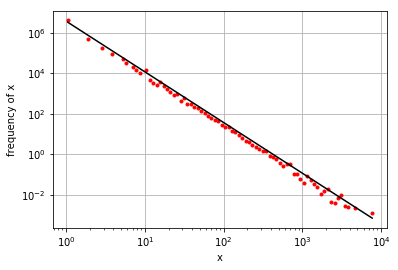

In [130]:
def get_logbin_mix(distr, binsize, binstart, bincross):
    distr_bin = {}
    bin_mix = {}
    b0 = binstart
    b1 = b0 + binsize
    bc = b0 + binsize * 0.5

    for x in sorted(distr.keys()):
        while math.log(x) >= b1:
            b0 += binsize
            b1 = b0 + binsize
            bc = b0 + binsize * 0.5
        xc = math.exp(bc)
        distr_bin[xc] = distr_bin.setdefault(xc, 0) + distr[x]
        if x < bincross:
            bin_mix[xc] = bin_mix.setdefault(xc, 0) + 1
        else:
            bin_mix[xc] = math.exp(b1) - math.exp(b0)

    return distr_bin, bin_mix

# log binning with mix
binsize = 0.1
binstart = math.log(min(xs))
bincross = 10
distr_bin, bin_mix = get_logbin_mix(distr, binsize, binstart, bincross)
for x in distr_bin.keys():
    distr_bin[x] /= bin_mix[x]
plot(distr_bin, num_x, alpha)
#print_distr(distr_bin, "distr_logbin_mix.txt")

Now both body and tail parts fit well with the functional form.
